# Delivery Route Optimization using RL and Informed Search

## Overview
This script evaluates and compares a variety of algorithms for solving the delivery route optimization problem. It uses a unified pipeline to test:
1.  **Reinforcement Learning Agents**: Q-Learning, SARSA, and DQN.
2.  **Informed Search Agents**: A* Search and Greedy Best-First Search.
#
The script uses `osmnx` to calculate real road network distances and leverages a Google AI model to provide a final analysis and explanation of the results.

In [7]:
import json
import time
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from IPython.display import display, Markdown, HTML
import folium
from folium.plugins import MarkerCluster

print("All libraries imported successfully!")
try:
    import osmnx as ox
    import networkx as nx
    OSMNX_AVAILABLE = True
except ImportError:
    OSMNX_AVAILABLE = False

from dqn import DQNAgent
from environment import DeliveryEnvironment
from google_LLM import GoogleAIModelExplainer
from osm_client import OSMClient
from q_learning import QLearningAgent
from sarsa import SarsaAgent
from informed_search import AStarAgent, GreedyBestFirstSearchAgent, InformedSearchAgent

if not OSMNX_AVAILABLE:
    print("\nWARNING: OSMnx is not available. The 'network' distance metric will fail.")
    print("Please install with: pip install osmnx")


All libraries imported successfully!


### Visualization and Helper Functions

In [8]:
def plot_delivery_route(env, route, file_path, agent_name=""):
    """
    Creates an interactive Folium map of the delivery route, showing the order of stops
    and layering the road network path over the straight-line path.
    """
    locations = env.locations
    if not isinstance(locations, np.ndarray) or locations.size == 0:
        print(f"    Cannot plot route for {file_path}: No locations provided.")
        return None
        
    map_center = np.mean(locations, axis=0)
    m = folium.Map(location=map_center, zoom_start=12, tiles="cartodbpositron")
    
    title_html = f'<h3 align="center" style="font-size:16px"><b>Route for {agent_name}</b></h3>'
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Depot Marker
    folium.Marker(
        locations[0], 
        popup="Depot", 
        tooltip="DEPOT (Start/End)", 
        icon=folium.Icon(color="red", icon="warehouse", prefix="fa")
    ).add_to(m)

    # Delivery Stop Markers with Numbers
    for i, loc_index in enumerate(route):
        if i == 0 or i == len(route) - 1:  # Skip depot
            continue
        folium.Marker(
            locations[loc_index],
            popup=f"Stop {i}: Location {loc_index}",
            tooltip=f"Stop #{i}",
            icon=folium.DivIcon(html=f'<div style="font-family: sans-serif; background-color: #3388ff; color: white; border-radius: 50%; width: 24px; height: 24px; text-align: center; line-height: 24px; font-weight: bold;">{i}</div>')
        ).add_to(m)

    # Layer 1: Straight-line connections (as-the-crow-flies)
    route_coords = [locations[i] for i in route]
    folium.PolyLine(
        route_coords, 
        color="purple", 
        weight=2, 
        opacity=0.8, 
        dash_array='5, 10',
        tooltip="Straight-line path"
    ).add_to(m)

    # Layer 2: Road network path
    if env.distance_metric == 'network' and env.osmnx_client and hasattr(env.osmnx_client, 'G'):
        G = env.osmnx_client.G
        for i in range(len(route) - 1):
            start_node = env.nodes[route[i]]
            end_node = env.nodes[route[i+1]]
            try:
                path_nodes = nx.shortest_path(G, start_node, end_node, weight='length')
                path_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path_nodes]
                folium.PolyLine(path_coords, color="green", weight=4, opacity=0.7, tooltip="Road network path").add_to(m)
            except (nx.NetworkXNoPath, KeyError):
                # If a road path isn't found, just skip it for that segment
                continue

    m.save(file_path)
    print(f"    ✓ Interactive map saved to {file_path}")
    return m

def plot_performance_comparison(results):
    """Plots bar charts comparing algorithm performance on distance and duration."""
    labels = list(results.keys())
    distances = [res['total_distance_km'] for res in results.values()]
    durations = [res['duration_sec'] for res in results.values()]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot for distance
    ax1.bar(labels, distances, color=plt.cm.plasma(np.linspace(0.4, 0.8, len(labels))), edgecolor='black')
    ax1.set_ylabel('Total Distance (km)')
    ax1.set_title('Algorithm Performance: Route Distance', fontsize=14, fontweight='bold')
    ax1.grid(True, axis='y', linestyle='--', alpha=0.6)
    for i, v in enumerate(distances):
        ax1.text(i, v + 0.5, f"{v:.2f}", ha='center', va='bottom')
        
    # Plot for duration
    ax2.bar(labels, durations, color=plt.cm.viridis(np.linspace(0.4, 0.8, len(labels))), edgecolor='black')
    ax2.set_ylabel('Execution Time (seconds)')
    ax2.set_title('Algorithm Performance: Execution Time', fontsize=14, fontweight='bold')
    ax2.grid(True, axis='y', linestyle='--', alpha=0.6)
    for i, v in enumerate(durations):
        ax2.text(i, v + 0.1, f"{v:.2f}s", ha='center', va='bottom')

    plt.setp(ax1.get_xticklabels(), rotation=20, ha="right")
    plt.setp(ax2.get_xticklabels(), rotation=20, ha="right")
    plt.tight_layout()
    plt.savefig("algorithm_performance_comparison.png", dpi=150)
    plt.show()

def plot_optimization_impact(initial_rewards, final_rewards):
    """
    Generates a plot comparing learning curves before and after optimization for RL agents.
    """
    rl_agent_names = list(initial_rewards.keys())
    if not rl_agent_names:
        return

    fig, axes = plt.subplots(len(rl_agent_names), 1, figsize=(12, 6 * len(rl_agent_names)), squeeze=False)
    
    for i, name in enumerate(rl_agent_names):
        ax = axes[i, 0]
        # Plot initial (before optimization) learning curve
        initial_curve = np.convolve(initial_rewards[name], np.ones(100)/100, mode='valid')
        ax.plot(initial_curve, label='Before Optimization (Tuning Phase)', color='orange', linestyle='--')
        
        # Plot final (after optimization) learning curve
        final_curve = np.convolve(final_rewards[name], np.ones(100)/100, mode='valid')
        ax.plot(final_curve, label='After Optimization (Final Run)', color='green')
        
        ax.set_title(f'Optimization Impact for {name}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Episodes')
        ax.set_ylabel('Moving Average Reward')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
        
    plt.tight_layout()
    plt.savefig("rl_optimization_impact.png", dpi=150)
    plt.show()


def generate_random_locations(city_name, num_locations):
    """Generates random coordinates within a given city's bounding box."""
    osm = OSMClient()
    bbox = osm.get_bounding_box(city_name)
    if not bbox: return None
    min_lat, max_lat, min_lon, max_lon = bbox
    lats = np.random.uniform(min_lat, max_lat, num_locations)
    lons = np.random.uniform(min_lon, max_lon, num_locations)
    return np.vstack((lats, lons)).T

def train_agent(agent, env, num_episodes, is_dqn=False):
    """A unified training function for all RL agent types."""
    reward_history = []
    for _ in range(num_episodes):
        state = env.reset(vectorized=is_dqn)
        done = False
        total_reward = 0
        while not done:
            possible_actions = env.get_possible_actions()
            if not possible_actions: break
            action = agent.choose_action(state, possible_actions)
            if action is None: break
            
            next_state_tuple, reward, done = env.step(action)
            
            if is_dqn:
                next_state = env._get_state(vectorized=True)
                agent.add_experience(state, action, reward, next_state, done)
                agent.update_model()
                state = next_state
            else:
                next_possible_actions = env.get_possible_actions()
                if isinstance(agent, SarsaAgent):
                    next_action = agent.choose_action(next_state_tuple, next_possible_actions)
                    agent.update_q_table(state, action, reward, next_state_tuple, next_action)
                    state = next_state_tuple
                    action = next_action
                else: # Q-Learning
                    agent.update_q_table(state, action, reward, next_state_tuple, next_possible_actions)
                    state = next_state_tuple
            
            total_reward += reward
        agent.decay_epsilon()
        reward_history.append(total_reward)
    return reward_history

def evaluate_agent(agent, env, is_dqn=False):
    """Evaluates the RL agent's performance to find the best route."""
    state = env.reset(vectorized=is_dqn)
    route = [env.start_pos_index]
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0
    
    while len(route) <= env.num_locations:
        possible_actions = env.get_possible_actions()
        if not possible_actions: break
        action = agent.choose_action(state, possible_actions)
        if action is None or action in route: break
        
        route.append(action)
        state, _, done = env.step(action)
        if is_dqn: state = env._get_state(vectorized=True)
        if done: break
            
    if route[-1] != env.start_pos_index:
        route.append(env.start_pos_index)
        
    agent.epsilon = original_epsilon
    total_distance = sum(env.distance_matrix[route[i]][route[i+1]] for i in range(len(route)-1))
    return route, total_distance / 1000


### Main Execution


Delivery Route Optimization Analysis
------------------------------------
City: Middlesbrough
Number of Parcels: 10
Distance Metric: network (Real road network)
RL Tuning Episodes: 500
RL Final Episodes: 3000


Initializing environment and building road network distance matrix...
Graph downloaded and processed. Using the largest connected component with 5967 nodes.
Calculating network distance matrix (this may take a while)...
  ✓ Environment ready in 6.90s. Matrix shape: (11, 11)

Phase 1: RL Agent Tuning
  Tuning Q-Learning for 500 episodes...
  Tuning SARSA for 500 episodes...
  Tuning DQN for 500 episodes...

Phase 2: Optimization and Final Run

--- Processing Agent: Q-Learning ---
  Applying optimized parameters and running for 3000 episodes...
  Evaluating final policy...
  ✓ Finished in 0.23s. Route Distance: 163.63 km
    ✓ Interactive map saved to route_Q-Learning.html
  >>> New best route found by Q-Learning! <<<

--- Processing Agent: SARSA ---
  Applying optimized paramete

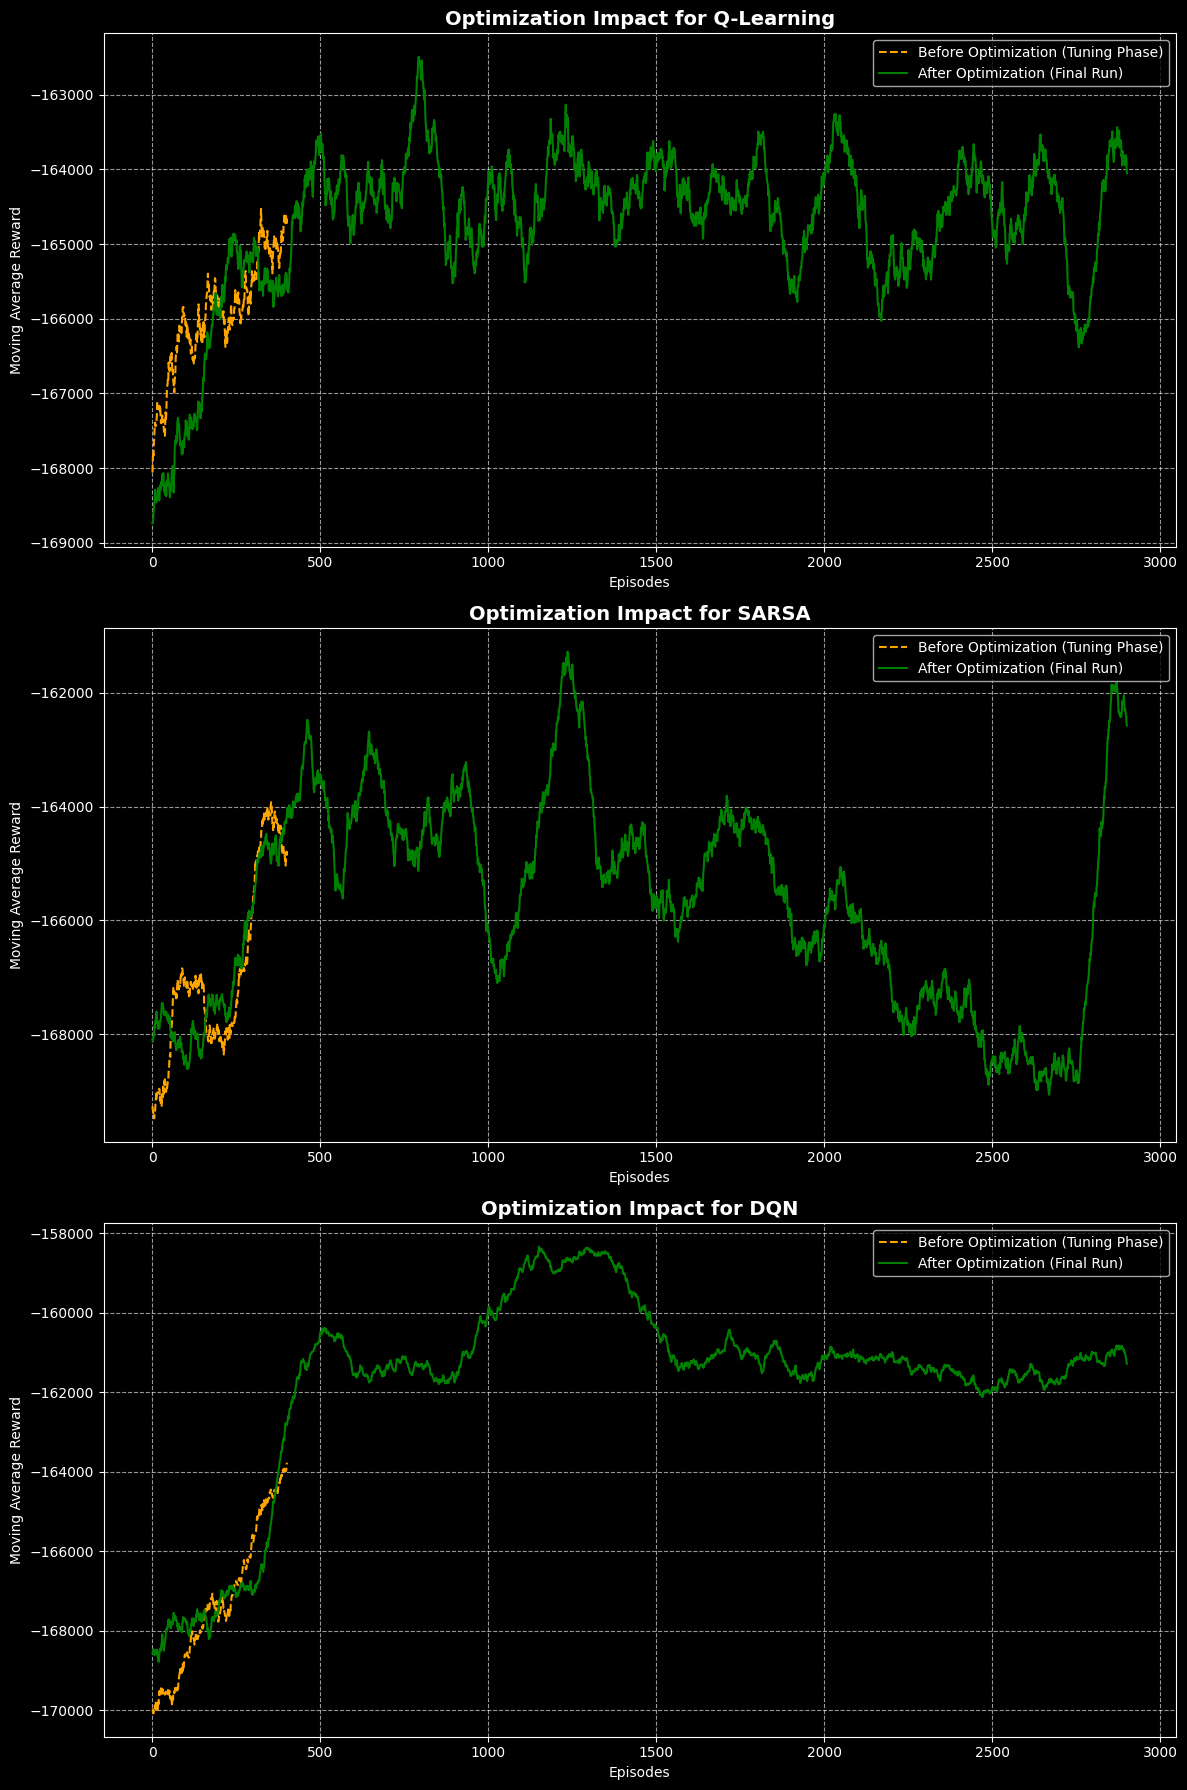

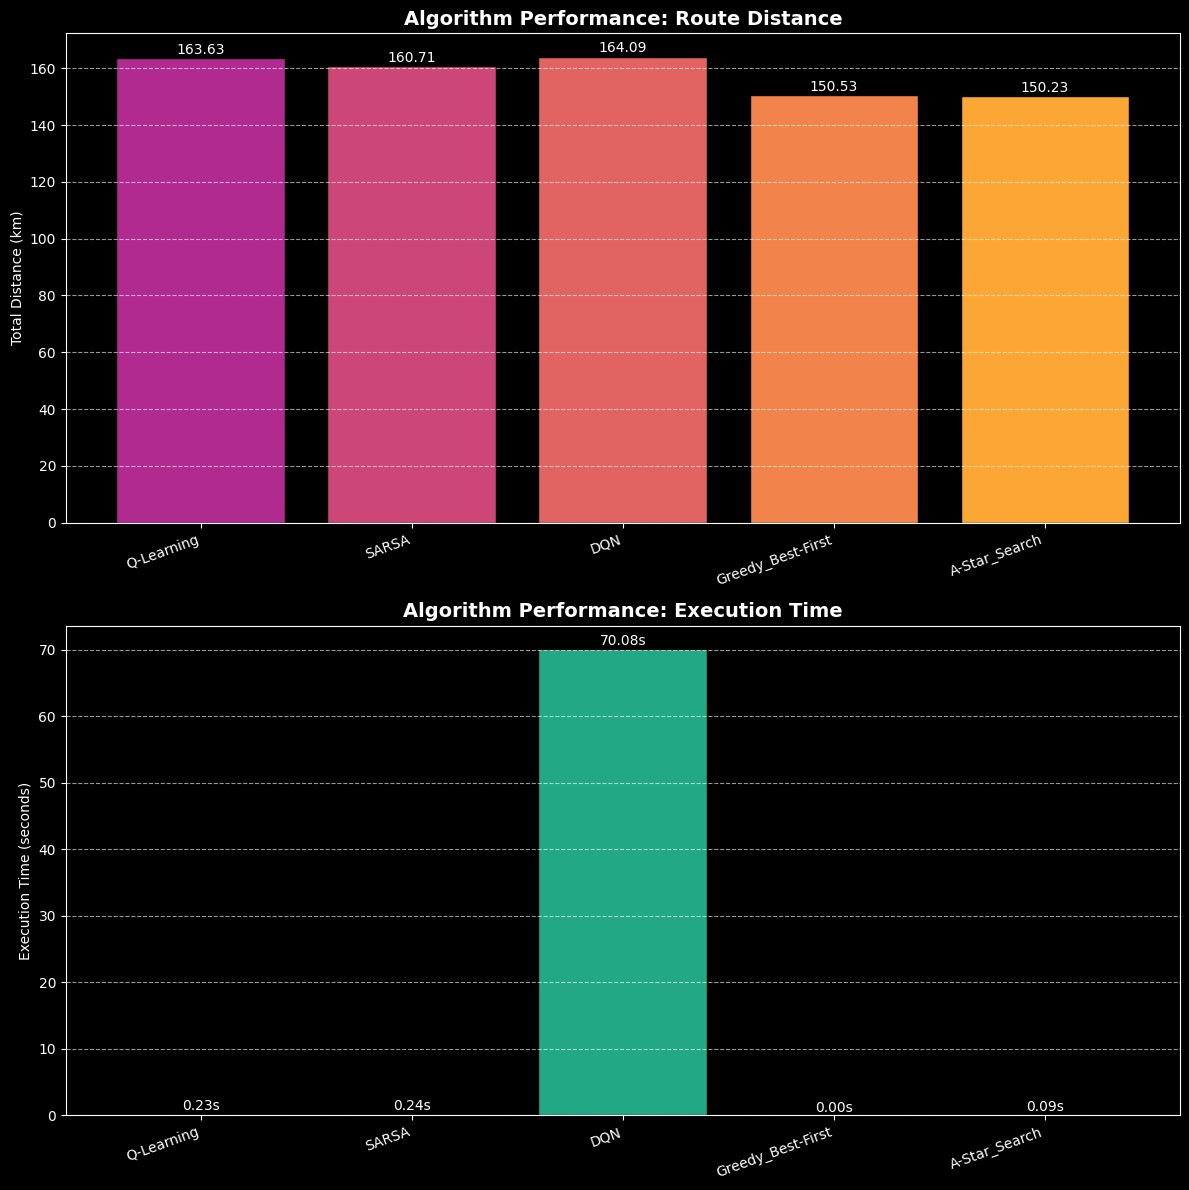

    ✓ Interactive map saved to best_overall_route_middlesbrough.html

Requesting AI-Powered Analysis from Google


TypeError: Object of type int64 is not JSON serializable

In [9]:
# --- CONFIGURATION ---
CITY = "Middlesbrough"
NUM_PARCELS = 10
DISTANCE_METRIC = 'network'
NUM_EPISODES_TUNE = 500
NUM_EPISODES_FINAL = 3000
load_dotenv()

print(f"""
Delivery Route Optimization Analysis
------------------------------------
City: {CITY}
Number of Parcels: {NUM_PARCELS}
Distance Metric: {DISTANCE_METRIC} (Real road network)
RL Tuning Episodes: {NUM_EPISODES_TUNE}
RL Final Episodes: {NUM_EPISODES_FINAL}
""")

# --- 1. SETUP ENVIRONMENT ---
if not OSMNX_AVAILABLE:
    exit("OSMnx is required for 'network' distance metric. Please install it and try again.")

locations_coords = generate_random_locations(CITY, NUM_PARCELS + 1)
if locations_coords is None:
    exit("Failed to generate locations. Exiting.")

print("\nInitializing environment and building road network distance matrix...")
start_time = time.time()
env = DeliveryEnvironment(locations=locations_coords, city_name=CITY, distance_metric=DISTANCE_METRIC)
print(f"  ✓ Environment ready in {time.time() - start_time:.2f}s. Matrix shape: {env.distance_matrix.shape}")

# --- 2. INITIALIZE AGENTS ---
rl_agents = {
    "Q-Learning": QLearningAgent(action_space=list(range(env.num_locations)), alpha=0.1, gamma=0.9, epsilon=1.0),
    "SARSA": SarsaAgent(action_space=list(range(env.num_locations)), alpha=0.1, gamma=0.9, epsilon=1.0),
    "DQN": DQNAgent(state_size=env.get_state_size(), action_size=env.num_locations, learning_rate=0.001, epsilon=1.0),
}
informed_search_agents = {
    "Greedy_Best-First": GreedyBestFirstSearchAgent(),
    "A-Star_Search": AStarAgent(),
}
all_agents = {**rl_agents, **informed_search_agents}

# --- 3. RL AGENT TUNING PHASE ---
print("\n" + "="*50)
print("Phase 1: RL Agent Tuning")
print("="*50)
initial_reward_histories = {}
for name, agent in rl_agents.items():
    print(f"  Tuning {name} for {NUM_EPISODES_TUNE} episodes...")
    initial_reward_histories[name] = train_agent(agent, env, NUM_EPISODES_TUNE, isinstance(agent, DQNAgent))

# --- 4. MODEL OPTIMIZATION & FINAL RUN ---
print("\n" + "="*50)
print("Phase 2: Optimization and Final Run")
print("="*50)
final_results = {}
best_route_info = {"agent": None, "route": [], "distance": float('inf')}
final_reward_histories = {}

# Define optimized hyperparameters
optimized_params = {
    "Q-Learning": {'alpha': 0.5, 'gamma': 0.95},
    "SARSA": {'alpha': 0.2, 'gamma': 0.98},
    "DQN": {'learning_rate': 0.0005}
}

for name, agent in all_agents.items():
    print(f"\n--- Processing Agent: {name} ---")
    start_time = time.time()
    
    if isinstance(agent, InformedSearchAgent):
        route, distance = agent.solve(env)
    else: # RL Agent
        print(f"  Applying optimized parameters and running for {NUM_EPISODES_FINAL} episodes...")
        params = optimized_params.get(name, {})
        agent_class = agent.__class__
        if name == "DQN":
            final_agent = agent_class(state_size=env.get_state_size(), action_size=env.num_locations, **params)
        else:
            final_agent = agent_class(action_space=list(range(env.num_locations)), **params)
        
        final_reward_histories[name] = train_agent(final_agent, env, NUM_EPISODES_FINAL, isinstance(final_agent, DQNAgent))
        print("  Evaluating final policy...")
        route, distance = evaluate_agent(final_agent, env, isinstance(final_agent, DQNAgent))

    duration = time.time() - start_time
    final_results[name] = {
        "total_distance_km": distance,
        "route_length": len(route),
        "duration_sec": duration,
        "route": route
    }
    print(f"  ✓ Finished in {duration:.2f}s. Route Distance: {distance:.2f} km")

    # Plot the route for this specific agent
    agent_map_filename = f"route_{name.replace(' ', '_')}.html"
    plot_delivery_route(env, route, agent_map_filename, agent_name=name)

    if distance < best_route_info["distance"]:
        best_route_info = {"agent": name, "route": route, "distance": distance}
        print(f"  >>> New best route found by {name}! <<<")

# --- 5. VISUALIZE AND EXPORT RESULTS ---
print("\n" + "="*50)
print("VISUALIZING AND EXPORTING RESULTS")
print("="*50)

plot_optimization_impact(initial_reward_histories, final_reward_histories)
plot_performance_comparison(final_results)

# Save a separate map for the best overall route
best_map_filename = f"best_overall_route_{CITY.lower()}.html"
plot_delivery_route(env, best_route_info["route"], best_map_filename, agent_name=f"Best Route ({best_route_info['agent']})")

# --- 6. FINAL AI-POWERED ANALYSIS ---
explainer = GoogleAIModelExplainer()
if explainer.available:
    print("\n" + "="*50)
    print("Requesting AI-Powered Analysis from Google")
    print("="*50)
    
    env_config = env.get_environment_summary()
    env_config["rl_tuning_episodes"] = NUM_EPISODES_TUNE
    env_config["rl_final_episodes"] = NUM_EPISODES_FINAL
    env_config["best_agent"] = best_route_info["agent"]
    env_config["best_distance_km"] = best_route_info["distance"]

    analysis = explainer.analyze_performance(final_results, env_config)
    display(Markdown(analysis))
else:
    print("\nGoogle AI Explainer not available. Skipping analysis.")

print("\nScript finished.")